In [1]:
using KomaMRI, MAT, Plots, LinearAlgebra

sys = Scanner()
sim_params = KomaMRICore.default_sim_params()
sim_params["return_type"] = "mat"
sim_params["sim_method"] = BlochDict()
sim_params["gpu"] = false

seq = read_seq("sequences/mpf_001_PhantomStudy_short_124.seq")

┌ Info: Loading sequence mpf_001_PhantomStudy_short_124.seq ...
└ @ KomaMRIFiles C:\Users\lucya\.julia\packages\KomaMRIFiles\Xc9Fh\src\Sequence\Pulseq.jl:339


Sequence[ τ = 5117.377 ms | blocks: 2003 | ADC: 1000 | GR: 6001 | RF: 962 | DEF: 11 ]

In [2]:
T1_ms, T2_ms = 2500, 800    # vial 1
#T1_ms, T2_ms = 1050, 140   # vial 6
T1, T2 = T1_ms / 1000, T2_ms / 1000

(2.5, 0.8)

In [3]:
x_pos = collect(range(-10e-3, 10e-3, length=1001))
obj = Phantom{Float64}(
    x = x_pos,
    y = zeros(length(x_pos)),
    z = zeros(length(x_pos)),
    T1 = fill(T1, length(x_pos)),
    T2 = fill(T2, length(x_pos)),
)

sig = simulate(obj, seq, sys; sim_params=sim_params)
sig_clean = dropdims(sig; dims=(3,4))

┌ Info: Simulation will be run on the CPU with only 1 thread. To enable multi-threading, start julia with --threads=auto
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:335
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = BlochDict(save_Mz=false)
│   spins = 1001
│   time_points = 42523
│   adc_points = 1000
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...   0%|█                             |  ETA: 2:55:25


Running simulation...   6%|██                            |  ETA: 0:03:22


Running simulation...  10%|███                           |  ETA: 0:01:57


Running simulation...  13%|████                          |  ETA: 0:01:25


Running simulation...  16%|█████                         |  ETA: 0:01:07


Running simulation...  19%|██████                        |  ETA: 0:00:55


Running simulation...  21%|███████        

 16.477940 seconds (21.77 M allocations: 3.589 GiB, 3.53% gc time, 77.04% compilation time: <1% of which was recompilation)


1000×1001 Matrix{ComplexF32}:
  -0.0157605-0.016571im    …    0.0171454-0.0121412im
  0.00220857-0.0227564im       0.00196862-0.0208021im
   0.0190043-0.0137594im       -0.0147703-0.015512im
   0.0238353+0.00456267im      -0.0222808+0.000282965im
   0.0136913+0.0203848im       -0.0157865+0.0163748im
 -0.00464246+0.02355im     …  0.000297352+0.0223964im
  -0.0192205+0.0122277im        0.0154602+0.0146392im
  -0.0206311-0.00606189im       0.0198763-0.00168782im
 -0.00811336-0.0193726im        0.0108131-0.0158849im
   0.0101074-0.0191374im      -0.00573996-0.0187761im
            ⋮              ⋱             ⋮
  0.00154667+0.00261297im     -0.00154262+0.00260558im
  0.00188363+0.00249625im     -0.00188633+0.00248831im
  0.00216626+0.00266819im     -0.00217391+0.00266482im
  0.00219144+0.002996im       -0.00219907+0.00299933im
  0.00192938+0.00324042im  …   -0.0019321+0.00324823im
   0.0015449+0.00321723im     -0.00154102+0.00322448im
   0.0012542+0.00292719im     -0.00124631+0.00292923im


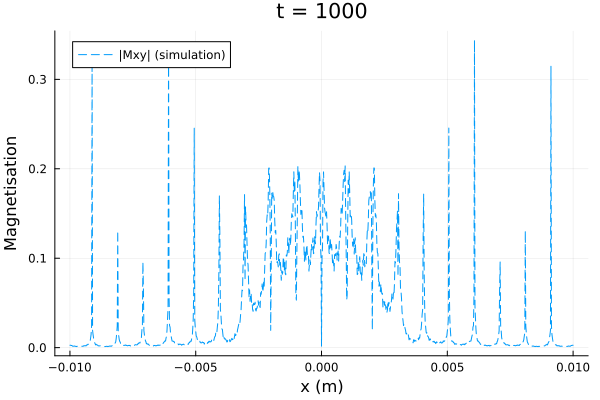

In [4]:
t_idx = 1000

Mxy_t = sig_clean[t_idx, :]  
Mmag = abs.(Mxy_t)

plot(
    x_pos, Mmag, label="|Mxy| (simulation)", 
    linestyle=:dash, ylabel="Magnetisation", xlabel="x (m)",
    title="t = $(t_idx)"
)

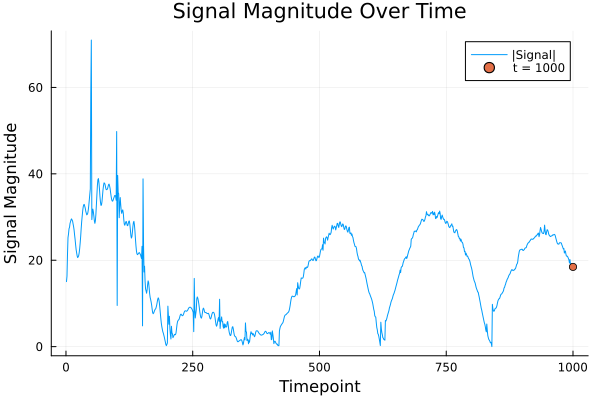

In [5]:
signal = vec(sum(sig_clean, dims=2))

plot(1:length(signal), abs.(signal),
     label="|Signal|",
     xlabel="Timepoint",
     ylabel="Signal Magnitude",
     title="Signal Magnitude Over Time")

scatter!([t_idx], [abs(signal[t_idx])],
         label="t = $t_idx")


In [6]:
x_pos = collect(range(-10e-3, 10e-3, length=201))

T2star = T2 * 0.3
T2prime = 1 / (1 / T2star - 1 / T2)
fwhm = 1 / (π * T2prime)  # Hz
γ = fwhm / 2

N_samples = 15
cutoff = 3 * γ
Δf_values = range(-cutoff, cutoff; length=N_samples) 
#Δf_values = zeros(15)

lorentz_pdf(f) = (γ / π) ./ (f.^2 .+ γ^2)
weights = lorentz_pdf.(Δf_values)
weights ./= sum(weights)
#weights = fill(1/15, 15)

obj_t2star = Phantom{}()
for (j, (Δf, w)) in enumerate(zip(Δf_values, weights))
    Δω = 2π * Δf 

    aux = Phantom{}(
        x = x_pos,
        #y = fill(j * 0.1, length(x_pos)),
        y = zeros(length(x_pos)),
        z = zeros(length(x_pos)),
        T1 = fill(T1, length(x_pos)),
        T2 = fill(T2, length(x_pos)),
        Δw = fill(Δω, length(x_pos)),
        ρ = fill(w, length(x_pos))
    )

    obj_t2star += aux
end

sig = simulate(obj_t2star, seq, sys; sim_params=sim_params)
sig_clean = dropdims(sig; dims=(3,4))
#signal_weighted = vec(sum(sig_clean, dims=2))

┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = BlochDict(save_Mz=false)
│   spins = 3015
│   time_points = 42523
│   adc_points = 1000
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...   0%|█                             |  ETA: 0:00:35


Running simulation...   1%|█                             |  ETA: 0:01:25


Running simulation...   2%|█                             |  ETA: 0:00:44


Running simulation...   2%|█                             |  ETA: 0:00:31


Running simulation...   4%|██                            |  ETA: 0:00:24


Running simulation...   5%|██                            |  ETA: 0:00:21


Running simulation...   6%|██                            |  ETA: 0:00:19


Running simulation...   7%|███                           |  ETA: 0:00:17


Running simulation...   8%|███                           |  ETA: 0:00:15


Running simulation...   9%|███         

  9.828915 seconds (4.84 M allocations: 7.840 GiB, 13.89% gc time)


1000×3015 Matrix{ComplexF32}:
  -0.00024828-0.000294639im  …    0.00027037-0.000223684im
   7.70334f-5-0.000378355im      -8.85474f-6-0.000349997im
  0.000351713-0.000184139im     -0.000286651-0.000218054im
  0.000381467+0.000148636im     -0.000365861+7.74211f-5im
  0.000147569+0.000383278im     -0.000191915+0.000325995im
 -0.000179197+0.000354375im  …   0.000107265+0.00035167im
 -0.000364771+8.67918f-5im       0.000316859+0.000139899im
 -0.000277947-0.000225346im      0.000287884-0.000154973im
   1.62821f-5-0.000358263im       4.36885f-5-0.000320975im
  0.000306294-0.000218911im     -0.000239642-0.000240843im
             ⋮               ⋱  
    2.9719f-5+3.63494f-5im       -2.96851f-5+3.62194f-5im
   3.79313f-5+3.9947f-5im         -3.8009f-5+3.9838f-5im
   3.99501f-5+4.85549f-5im       -4.00832f-5+4.85441f-5im
   3.40304f-5+5.56766f-5im       -3.41242f-5+5.5771f-5im
   2.41645f-5+5.58094f-5im   …    -2.4153f-5+5.59411f-5im
   1.72578f-5+4.84506f-5im       -1.71506f-5+4.8526f-5im
   1

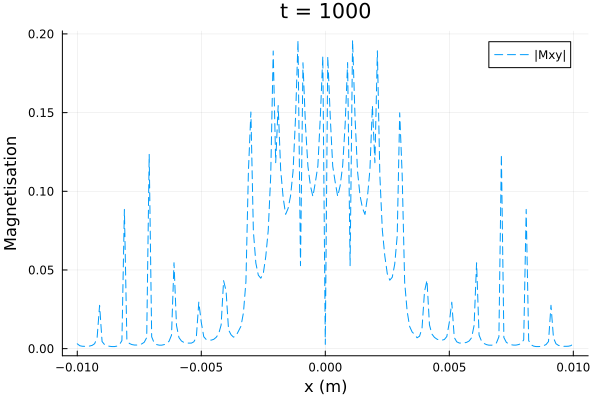

In [7]:
N_voxels = 201
N_samples = 15

data_reshaped = Array{eltype(sig_clean)}(undef, 1000, N_samples, N_voxels)

for v in 1:N_voxels
    for s in 1:N_samples
        idx = (s - 1) * N_voxels + v   # every 201st element
        data_reshaped[:, s, v] = sig_clean[:, idx]
    end
end

data_summed = sum(data_reshaped, dims=2)   
data_summed   = dropdims(data_summed; dims=2) 

t_idx = 1000
Mxy_t = data_summed[t_idx, :]
Mmag = abs.(Mxy_t)

plot(x_pos, Mmag, label="|Mxy|", linestyle=:dash, ylabel="Magnetisation", xlabel="x (m)", title="t = $(t_idx)")

In [8]:
slice_thickness = 10e-3  
inside_mask = abs.(x_pos) .<= (slice_thickness / 2)
outside_mask = .!inside_mask

S_total   = sum(Mxy_t)
S_inside  = sum(Mxy_t[inside_mask])
S_outside = sum(Mxy_t[outside_mask])

println("Complex signal:   ", S_total, "          mag: ", abs(S_total))
println("--> inside ±5mm:    ", S_inside, "         mag: ", abs(S_inside))
println("--> outside ±5mm:   ", S_outside, "       mag: ", abs(S_outside))
println(abs(S_outside) / abs(S_total) * 100)

Complex signal:   0.001842791f0 + 3.6136353f0im          mag: 3.6136358
--> inside ±5mm:    0.0018490274f0 + 3.725988f0im         mag: 3.7259884
--> outside ±5mm:   -6.282935f-6 - 0.11235286f0im       mag: 0.11235286
3.1091363


In [9]:
# Ratio outside/inside at each time point
ratios_per_t = [
    abs(sum(data_summed[t, outside_mask])) /
    abs(sum(data_summed[t, inside_mask]))
    for t in 1:size(data_summed, 1)
]
sum_ratio = sum(ratios_per_t)
average_percent = sum_ratio/1000 * 100

println("Average of outside/inside ratios over all time points: ", average_percent)

Average of outside/inside ratios over all time points: 24.9528


In [11]:
function simulate_slice_profile_x(
    seq::Sequence; x=range(-2.e-2, 2.e-2, 200), sim_params=Dict{String,Any}("Δt_rf" => 1e-6)
)
    sim_params["return_type"] = "state"
    sys = Scanner()
    obj = Phantom{Float64}(; x=Array(x), z=zeros(size(x)))
    mag = simulate(obj, seq, sys; sim_params)
    return mag
end
z = -0.01:0.000001:0.01
slice_prof= simulate_slice_profile_x(seq[3]; x=z)

┌ Info:  
│   The GPU functionality is being called but no GPU backend is loaded 
│   to access it. Add 'using CUDA / Metal / AMDGPU / oneAPI' to your 
│   code. Defaulting back to the CPU. (No action is required if you want
│   to run on the CPU).
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\GPUFunctions.jl:46
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 20001
│   time_points = 1021
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...   8%|███                           |  ETA: 0:00:55


Running simulation...  17%|██████                        |  ETA: 0:00:26


Running simulation...  25%|████████                      |  ETA: 0:00:16


Running simulation...  33%|███████████                   |  ETA: 0:00:11


Running simulation...  54%|█████████████████             |  ETA: 0:00:05


Running sim

  6.594952 seconds (9.32 M allocations: 500.185 MiB, 7.28% gc time, 80.03% compilation time)


Mag{Float32}(ComplexF32[0.000183965f0 - 0.00019145898f0im, 0.00018346134f0 - 0.00019194279f0im, 0.00018294605f0 - 0.00019242796f0im, 0.00018244331f0 - 0.0001929013f0im, 0.00018192771f0 - 0.00019337572f0im, 0.00018141775f0 - 0.00019385175f0im, 0.00018090828f0 - 0.00019433303f0im, 0.00018039293f0 - 0.0001948061f0im, 0.00017989209f0 - 0.00019529012f0im, 0.00017937897f0 - 0.00019576415f0im  …  -0.00017937897f0 - 0.00019576415f0im, -0.00017989209f0 - 0.00019529012f0im, -0.00018039293f0 - 0.0001948061f0im, -0.00018090828f0 - 0.00019433303f0im, -0.00018141775f0 - 0.00019385175f0im, -0.00018192771f0 - 0.00019337572f0im, -0.00018244331f0 - 0.0001929013f0im, -0.00018294605f0 - 0.00019242796f0im, -0.00018346134f0 - 0.00019194279f0im, -0.000183965f0 - 0.00019145898f0im], Float32[1.0000025, 1.0000025, 1.0000025, 1.0000026, 1.0000026, 1.0000026, 1.0000026, 1.0000026, 1.0000026, 1.0000027  …  1.0000027, 1.0000026, 1.0000026, 1.0000026, 1.0000026, 1.0000026, 1.0000026, 1.0000025, 1.0000025, 1.0000025]

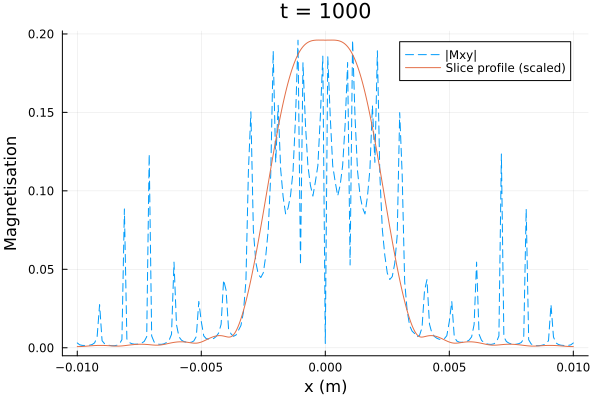

In [22]:
scaled_profile = abs.(slice_prof.xy) .* (maximum(Mmag) / maximum(abs.(slice_prof.xy)))

plot(x_pos, Mmag, label="|Mxy|", linestyle=:dash,
     ylabel="Magnetisation", xlabel="x (m)", title="t = $(t_idx)")
plot!(z, scaled_profile, label="Slice profile (scaled)")


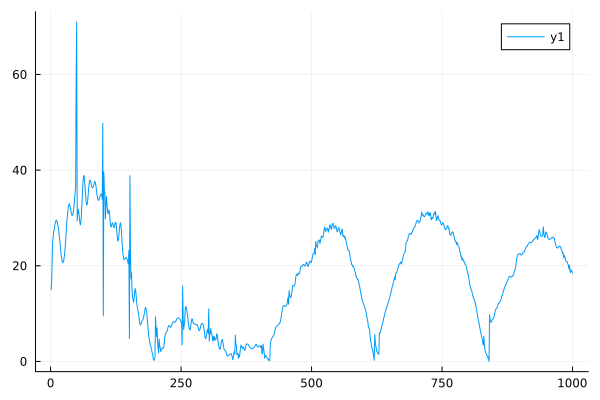

In [ ]:
plot(abs.(signal))